In [1]:
#!pip install catboost
#!pip install transformers
#!pip install nltk
#!pip install nlpaug
#!pip install evaluate

In [2]:
! pip install -r requirements.txt

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12.8/12.8 MB 23.6 MB/s eta 0:00:00
Processing /colabtools/dist/google-colab-1.0.0.tar.gz (from -r requirements.txt (line 143))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/colabtools/dist/google-colab-1.0.0.tar.gz'



In [3]:
import json
import gc
import random
import re
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from copy import deepcopy
from IPython.display import clear_output
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from scipy.sparse import coo_matrix, hstack
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    multilabel_confusion_matrix,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import catboost
from catboost import CatBoostClassifier, Pool
from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertForSequenceClassification,
    BertTokenizer,
    AdamW,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup,
)
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm.notebook import tqdm
from transformers import get_linear_schedule_with_warmup

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.augmenter.word as naw
import nlpaug.flow as nafc
from nlpaug.util import Action

In [4]:
from src.functions_bert import dataset, inference, f1_score_func_m, trainer, evaluate, trainer_pipeline
from src.functions_LR import count_words, text2emb_bert, dataset_pipeline

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

–ó–∞–≥—Ä—É–∑–∏–º –¥–∞–Ω–Ω—ã–µ

In [6]:
PATH = 'GBC_NLP_test_news_sample.json'
texts = []
labels = []

with open(PATH) as f:
    data = json.load(f)

for row in data:
    texts.append(row['content'])
    labels.append(row['classification'])

f.close()

In [7]:
df = pd.DataFrame({'text' : texts, 'label' : labels})
df.head()

text                   label
0  The Mines of Dalarnia Update 1.4: Rechained is...  development, specified
1    Mines of Dalarnia Mainnet‚ÄîUpdate 1.4: Rechained  development, specified
2  Kava in the news [kava 14 accelerates cosmos e...  development, specified
3  SEC responsed: We are pleased that the court f...                     sec
4                    Build on Base Mainnet with 1RPC  development, specified

### EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    835 non-null    object
 1   label   835 non-null    object
dtypes: object(2)
memory usage: 13.2+ KB


–£ –Ω–∞—Å 835 –æ–±—ä–µ–∫—Ç–æ–≤ –±–µ–∑ –ø—Ä–æ–ø—É—Å–∫–æ–≤

In [9]:

df['label'].value_counts()

development, specified     280
partnership, non-crypto    264
development                 66
announcement promise        59
legal, negative             39
start of burn/buyback       32
legal, positive             21
exploit                     17
raise                       16
negative                    12
selling                     12
ripple                      10
positive                     4
sec                          1
negative rebuttal            1
interested                   1
Name: label, dtype: int64

16 –∫–ª–∞—Å—Å–æ–≤ —Å —Å–∏–ª—å–Ω—ã–º –¥–∏—Å–±–∞–ª–∞–Ω—Å–æ–º

##### –î—É–±–ª–∏–∫–∞—Ç—ã

In [10]:
df[df.duplicated(subset=['text'], keep=False)==True]

text  \
13   It is with great excitement that we announce t...   
14   It is with great excitement that we announce t...   
112  MULTICHAIN FANTOM BRIDGE POSSIBLY DRAINED, AFF...   
113  MULTICHAIN FANTOM BRIDGE POSSIBLY DRAINED, AFF...   
121  EMURGO Ventures Invests in Magic Square To Fur...   
122  EMURGO Ventures Invests in Magic Square To Fur...   
126  Multichain Team Confirms Exploit Across Fantom...   
127  Multichain Team Confirms Exploit Across Fantom...   
226  Optimism, Aptos and ApeCoin set for largest to...   
227  Optimism, Aptos and ApeCoin set for largest to...   
228  Revolut to Delist Solana, Polygon, And Cardano...   
229  Revolut to Delist Solana, Polygon, And Cardano...   
271  Buckle up! Nairobi, the 14th protocol upgrade ...   
272  Buckle up! Nairobi, the 14th protocol upgrade ...   
334  Frax Finance to launch Ethereum Layer 2 named ...   
335  Frax Finance to launch Ethereum Layer 2 named ...   
337  Bakkt delists Solana, Polygon and Cardano amid...   
338  Bakkt delists Solana, Polygon and Cardano amid...   
342  Bakkt to Delist Solana, Cardano and Polygon Fo...   
343  Bakkt to Delist Solana, Cardano and Polygon Fo...   
360  Alchemy Pay Collaborates with aelf to Provide ...   
380  The Graph Starts Migrating its Settlement Laye...   
381  The Graph Starts Migrating its Settlement Laye...   
398  Alchemy Pay Collaborates with aelf to Provide ...   
461  Optimism, Sui set for large token unlocks, wor...   
478  Algorand and Flow Crash to All-Time Lows Follo...   
479  Algorand and Flow Crash to All-Time Lows Follo...   
481  Solana, Cardano, Polygon Fight Back Against SE...   
482  Solana, Cardano, Polygon Fight Back Against SE...   
483  Solana, Cardano, Polygon Fight Back Against SE...   
509  Optimism, Sui set for large token unlocks, wor...   
511  By combining @dapdapio's community-driven iden...   
512  By combining @dapdapio's community-driven iden...   
568  SEC Allege the Following Coins Are Securities ...   
569  SEC Allege the Following Coins Are Securities ...   
785  In anticipation of the Optimism Bedrock upgrad...   
786  In anticipation of the Optimism Bedrock upgrad...   
805  LDO staking and a warrant canary [proposal int...   
806  LDO staking and a warrant canary [proposal int...   
807  Exciting news for !   introduces Advanced Anal...   
808  Exciting news for !   introduces Advanced Anal...   
815  Congratulations to  for shipping V2! Lido is k...   
816  Congratulations to  for shipping V2! Lido is k...   
832  Under the new proposal process, we are delight...   
833  Under the new proposal process, we are delight...   

                       label  
13   partnership, non-crypto  
14   partnership, non-crypto  
112                  exploit  
113                  exploit  
121  partnership, non-crypto  
122  partnership, non-crypto  
126                  exploit  
127                  exploit  
226                  selling  
227   development, specified  
228          legal, negative  
229          legal, negative  
271   development, specified  
272   development, specified  
334   development, specified  
335   development, specified  
337          legal, negative  
338          legal, negative  
342          legal, negative  
343          legal, negative  
360  partnership, non-crypto  
380   development, specified  
381   development, specified  
398  partnership, non-crypto  
461                  selling  
478          legal, negative  
479          legal, negative  
481          legal, negative  
482          legal, negative  
483          legal, negative  
509                    raise  
511  partnership, non-crypto  
512  partnership, non-crypto  
568          legal, negative  
569          legal, negative  
785              development  
786              development  
805              development  
806              development  
807              development  
808              development  
815              development  
816              development  
832              

–í –¥–∞–Ω–Ω—ã—Ö –µ—Å—Ç—å –¥—É–±–ª–∏–∫–∞—Ç—ã.  
–ù–µ—Å–∫–æ–ª—å–∫–æ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–∞—Ç –∫ —Ä–∞–∑–Ω—ã–º –∫–ª–∞—Å—Å–∞–º.  
–£–¥–∞–ª–∏–º –∏—Ö –∏–∑ –Ω–∞—à–µ–π –≤—ã–±–æ—Ä–∫–∏.

In [11]:
df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
print(f'–ö–æ–ª-–≤–æ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ –ø–æ—Å–ª–µ –æ—Ç—á–∏—Å—Ç–∫–∏: {df.duplicated(subset=["text"]).sum()}')
print()
df.info()

–ö–æ–ª-–≤–æ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ –ø–æ—Å–ª–µ –æ—Ç—á–∏—Å—Ç–∫–∏: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    812 non-null    object
 1   label   812 non-null    object
dtypes: object(2)
memory usage: 12.8+ KB


–ù–∞—à–ª–∏ –∏ —É–¥–∞–ª–∏–ª–∏ 33 –¥—É–±–ª–∏–∫–∞—Ç–æ–≤

#### –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω —Ç–µ–∫—Å—Ç–æ–≤

In [12]:
df['text_len'] = df.text.str.len()

<Axes: >

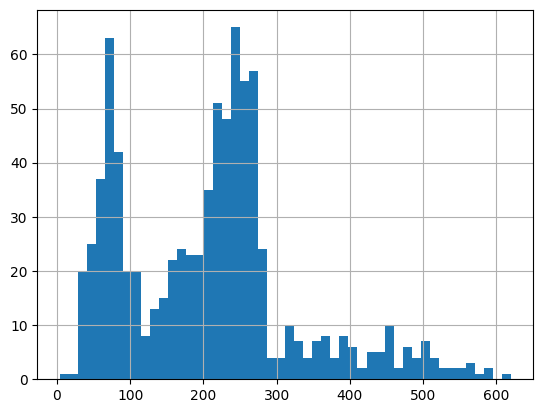

In [13]:
df['text_len'].hist(bins=50)

–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –±–∏–º–æ–¥–∞–ª—å–Ω–æ–µ —Å –º–æ–¥–æ–π –≤ 80 –∏ 250.  
–ú–æ–∂–Ω–æ —Å–∫–∞–∑–∞—Ç—å, —á—Ç–æ –±–æ–ª—å—à–∞—è —á–∞—Å—Ç—å —Ç–µ–∫—Å—Ç–∞ –ª–µ–∂–∏—Ç –≤ –¥–∏–∞–ø–∞–∑–æ–Ω–µ 280 —Å–∏–º–≤–æ–ª–æ–≤

In [14]:
df.groupby('label')['text_len'].agg(['count', 'mean', 'median', 'std'])

count        mean  median         std
label                                                         
announcement promise        59  191.898305   164.0  138.749799
development                 61  259.557377   255.0  157.355492
development, specified     276  213.865942   223.5  110.722685
exploit                     15   72.333333    70.0   11.962242
interested                   1  228.000000   228.0         NaN
legal, negative             32  136.937500    81.0  103.748125
legal, positive             21  223.190476   225.0  148.468050
negative                    12   86.166667    76.5   31.871427
negative rebuttal            1  160.000000   160.0         NaN
partnership, non-crypto    260  223.203846   226.0  104.958756
positive                     4   81.500000    75.5   48.308039
raise                       15  173.333333   165.0  101.898175
ripple                      10  151.100000   119.5   99.051558
sec                          1  276.000000   276.0         NaN
selling                     12  147.416667    78.5  116.715239
start of burn/buyback       32  209.250000   198.0  104.550651

<Axes: >

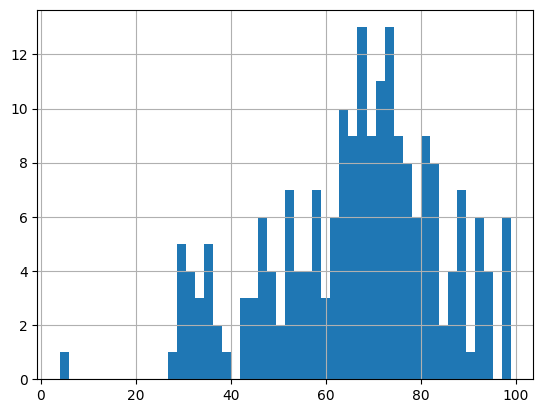

In [15]:
df.query('text_len < 100')['text_len'].hist(bins=50)

In [16]:
df.query('text_len < 100').sort_values('text_len').head()

text                    label  text_len
107                           Soon     announcement promise         4
415    Synthetix lists stETH Perps   development, specified        27
530  Flux partners with Octominer!  partnership, non-crypto        29
545  DeFining news: June 9th, 2023     announcement promise        29
19   Open Exchange Adds FTX Claims                 positive        29

–ö–æ—Ä–æ—Ç–∫–∏—Ö –±–µ—Å—Å–º—ã—Å–ª–µ–Ω–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤ –Ω–µ –∑–∞–º–µ—á–µ–Ω–æ.

#### –£–±–µ—Ä–µ–º –∫–ª–∞—Å—Å—ã —Å –∫–æ–ª-–≤–æ–º –æ–±—Ä–∞–∑—Ü–æ–≤ < 5

In [17]:
df['label'].value_counts()

development, specified     276
partnership, non-crypto    260
development                 61
announcement promise        59
start of burn/buyback       32
legal, negative             32
legal, positive             21
raise                       15
exploit                     15
negative                    12
selling                     12
ripple                      10
positive                     4
sec                          1
negative rebuttal            1
interested                   1
Name: label, dtype: int64

In [18]:
df['label_count'] = df.groupby('label')['label'].transform('count')
df = df.query('label_count > 5')

In [19]:

df['label'].value_counts()

development, specified     276
partnership, non-crypto    260
development                 61
announcement promise        59
start of burn/buyback       32
legal, negative             32
legal, positive             21
raise                       15
exploit                     15
negative                    12
selling                     12
ripple                      10
Name: label, dtype: int64

In [20]:
df = df.reset_index(drop=True)

#### –û—Ü–µ–Ω–∏–º —Å–æ–¥–µ—Ä–∂–∏–º–æ–µ –Ω–∞—à–∏—Ö —Ç–∞—Ä–≥–µ—Ç–æ–≤

–°–∞–º–∏ –ø–æ —Å–µ–±–µ –¥–∞–Ω–Ω—ã–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è—é—Ç —Å–æ–±–æ–π –∑–∞–∫–æ–ª–æ–≤–∫–∏ –Ω–æ–≤–æ—Å—Ç–Ω—ã–µ –Ω–∞ —Ä–∞–∑–ª–∏—á–Ω—ã–µ —Ç–∞–º–∞—Ç–∏–∫–∏.  

development, specified - —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∞, —É—Ç–æ—á–Ω–µ–Ω–Ω–∞—è  
partnership, non-crypto - –ø–∞—Ä—Ç–Ω–µ—Ä—Å—Ç–≤–æ, –Ω–µ –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç–Ω–æ–µ  
development - —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∞  
announcement promise - –æ–±–µ—â–∞–Ω–∏–µ –æ–±—ä—è–≤–ª–µ–Ω–∏—è  
start of burn/buyback - –Ω–∞—á–∞–ª–æ —Å–∂–∏–≥–∞–Ω–∏—è/–≤—ã–∫—É–ø–∞  
legal, negative - —é—Ä–∏–¥–∏—á–µ—Å–∫–∏, –Ω–µ–≥–∞—Ç–∏–≤–Ω–æ  
legal, positive - —é—Ä–∏–¥–∏—á–µ—Å–∫–∏, –ø–æ–∑–∏—Ç–∏–≤–Ω–æ  
raise - –ø—Ä–∏–≤–ª–µ—á–µ–Ω–∏–µ (—Ñ–∏–Ω–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–∏—è)  
exploit - —ç–∫—Å–ø–ª—É–∞—Ç–∏—Ä–æ–≤–∞—Ç—å  
negative - –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã–π  
selling - –ø—Ä–æ–¥–∞–∂–∞  
ripple - –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç–∞ Ripple  

–¢—É—Ç —Å—Ä–∞–∑—É –≤–∏–¥–Ω–æ –Ω–µ—Å–∫–æ–ª—å–∫–æ –ø—Ä–æ–±–ª–µ–º:
1. –ï—Å—Ç—å –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ –∫–∞–∫ –ø–æ —Å–æ–¥–µ—Ä–∂–∞–Ω–∏—é –∑–∞–≥–æ–ª–æ–≤–∫–∞ (selling, development, ...), —Ç–∞–∫ –ø–æ —ç–º–æ—Ü–∏–æ–Ω–∞–ª—å–Ω–æ–º—É —Å–æ–¥–µ—Ä–∂–∞–Ω–∏—é —Ç–µ–∫—Å—Ç–∞ (negative).  
–ü—Ä–∏ —ç—Ç–æ–º –æ–¥–Ω–∞ —Ç–µ–º–∞ –ø–æ —Å–æ–¥–µ—Ä–∂–∞–Ω–∏—é —Ä–∞–∑–±–∏—Ç–∞ –Ω–∞ —Ç–µ–º—ã –ø–æ —ç–º–æ—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ (legal negative, legal positive).
2. –î–≤–µ –±–æ–ª—å—à–∏–µ –≥—Ä—É–ø–ø—ã development –∏ development specified –≤–æ–æ–±—â–µ–º –æ—Ç–Ω–æ—Å—è—Ç—Å—è –∫ –æ–¥–Ω–æ–π –≥—Ä—É–ø–ø–µ –ø–æ —Å–æ–¥–µ—Ä–∂–∞–Ω–∏—é, –Ω–æ —Ä–∞–∑–ª–∏—á–∞—é—Ç—Å—è –≥–ª—É–±–∏–Ω–æ–π –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞.  

–ü—Ä–æ–±–ª–µ–º—ã:   
–í—Å–µ —ç—Ç–æ –≤ –∫—É–ø–µ —Å –¥–∏—Å–±–∞–ª–∞–Ω—Å–æ–º –∏ –º–∞–ª–µ–Ω—å–∫–æ–π –≤—ã–±–æ—Ä–∫–æ–π —Å–æ–∑–¥–∞—Å—Ç  –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã–Ω–µ —Å–ª–æ–∂–Ω–æ—Å—Ç–∏ –ø—Ä–∏ –æ–±—É—á–µ–Ω–∏–∏ —Ö–æ—Ä–æ—à–µ–≥–æ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–≤.

–ì–∏–ø–æ—Ç–µ–∑—ã:  
1. –û–±—É—á–∏—Ç—å –Ω–µ—Å–∫–æ–ª—å–∫–æ –º–æ–¥–µ–ª–µ–π –Ω–∞ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ä–∞–∑–Ω—ã—Ö —Å–æ—Å—Ç–∞–≤–ª—è—é—â–∏—Ö.  
–î–æ–ø—É—Å—Ç–∏–º –æ–±—É—á–∏—Ç—å –º–æ–¥–µ–ª—å –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –ª—é–±–æ–≥–æ legit –∏ —É–∂–µ –ø–æ—Ç–æ–º –¥–µ–ª–∏—Ç—å –∏—Ö –Ω–∞ positive –∏ negative.  
2. –û–±—É—á–∏—Ç—å –æ–¥–Ω—É –±–æ–ª—å—à—É—é —Å–ª–æ–∂–Ω—É—é –º–æ–¥–µ–ª—å, –∫–æ—Ç–æ—Ä–∞—è –±—ã –º–æ–≥–ª–∞ —Ä–∞–∑–¥–µ–ª–∏—Ç—å –∫–ª–∞—Å—Å—ã.  
–ù–∞ —É–º –ø—Ä–∏—Ö–æ–¥–∏—Ç –∫–∞–∫–æ–π-–Ω–∏–±—É–¥—å BERT, –µ–≥–æ –¥–∞–∂–µ –Ω–µ –æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ –æ–±—É—á–∞—Ç—å –ø–æ–ª–Ω–æ—Å—Ç—å—é, –º–æ–∂–Ω–æ –¥–æ–æ–±—É—á–∏—Ç—å —Ç–æ–ª—å–∫–æ "–≥–æ–ª–æ–≤—É"

In [21]:
for t in df['label'].unique():
    print(f"label: {t}")
    for idx in range(6):
        print(f'''{idx}: {df.query(f'label =="{t}"')['text'].iloc[idx]}''')

    print('____')

label: development, specified
0: The Mines of Dalarnia Update 1.4: Rechained is now LIVE! This new version reintroduces all of the previous blockchain features along with new ones on BSC Mainnet, including: 1‚É£ Off-chain and on-chain crafting. 2‚É£ New competition mode. 3‚É£ Spacehop. 4‚É£ New monster, and‚Ä¶
1: Mines of Dalarnia Mainnet‚ÄîUpdate 1.4: Rechained
2: Kava in the news [kava 14 accelerates cosmos ecosystem expansion]
3: Build on Base Mainnet with 1RPC
4: No better time than to @buildonbase with Base Mainnet now open to builders - devs, access the network with our dedicated 1RPC endpoint and start building the on-chain future today We can't wait to see what you'll get up to:
5: Dive deep into 14! Introducing the 'internal bridge', a secure module enabling seamless interoperability between Cosmos & Ethereum ecosystems. Effortlessly convert tokens into ERC20 for use in the environment
____
label: partnership, non-crypto
0: SimWin Sports and Immutable: Bringing Digital Ownersh

–¢–∞–∫–∂–µ –≤ —Ç–µ–∫—Å—Ç–µ –æ—á–µ–Ω—å –º–Ω–æ–≥–æ —Å–∏–º–æ–≤–æ–ª–æ–≤, –∞–±—Ä–∏–≤–∏–∞—Ç—É—Ä, —á–∏—Å–µ–ª, —Å—Å—ã–ª–æ–∫.  
–û—á–µ–≤–∏–¥–Ω–æ, –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ –∏–∑ —Ç–∞–∫–∏—Ö –æ–±–æ–∑–Ω–∞—á–µ–Ω–∏–π –º–æ–≥—É –ø–æ–º–æ–≥–∞—Ç—å –º–æ–¥–µ–ª–∏ –æ–ø—Ä–µ–¥–µ–ª—è—Ç—å –∫–ª–∞—Å—Å –∑–∞–≥–æ–ª–æ–≤–∫–∞, –Ω–æ –≤ —Ç–æ–∂–µ –≤—Ä–µ–º—è –∏–∑–±—ã—Ç–æ—á–Ω–æ –Ω–∞—Ä–∞—â–∏–≤–∞—Ç—å —Ä–∞–∑–º–µ—Ä—ã —Å–ª–æ–≤–∞—Ä—è –∏ —Å–æ–∑–¥–∞–≤–∞—Ç—å –≤—Ä–µ–¥–Ω—ã–π —à—É–º.

### –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö

#### –¢–æ–∫–µ–Ω–∏–∑–∏—Ä—É–µ–º —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é

–û—Ç—Å–æ—Ä—Ç–∏—Ä—É–µ–º –∏—Ö –ø–æ –∫–æ–ª-–≤—É (–¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏) –∏ —Å–æ–∑–¥–∞–¥–∏–º —Å–ª–æ–≤–∞—Ä—å –º–µ—Ç–∫–∏ –∫–ª–∞—Å—Å : —Ç–æ–∫–µ–Ω

In [22]:
lable2token = {token: idx for idx, token in enumerate(df['label'].value_counts().index)}
print(lable2token)

{'development, specified': 0, 'partnership, non-crypto': 1, 'development': 2, 'announcement promise': 3, 'start of burn/buyback': 4, 'legal, negative': 5, 'legal, positive': 6, 'raise': 7, 'exploit': 8, 'negative': 9, 'selling': 10, 'ripple': 11}


In [23]:
df['labels_token'] = df['label'].replace(lable2token)

<Axes: >

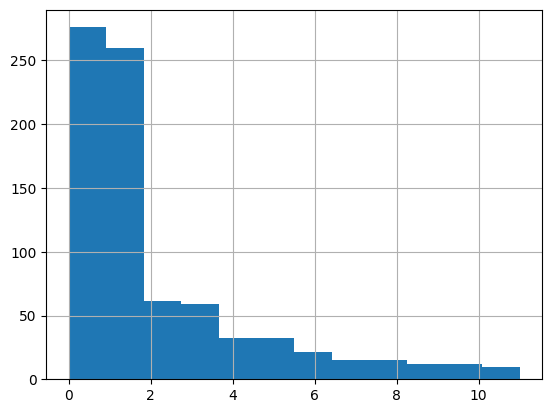

In [24]:

df['labels_token'].hist(bins=12)

#### –û—Ç—á–∏—Å—Ç–∏–º –∏ –ø–æ–¥–≥–æ—Ç–æ–≤–∏–º –¥–∞–Ω–Ω—ã–µ

–ù–∞–ø–∏—à–µ–º –Ω–µ—Å–∫–æ–ª—å–∫–æ —Ñ—É–Ω–∫—Ü–∏–π –¥–ª—è —Ä–∞–∑–Ω–æ–≥–æ —Ç–∏–ø–∞ –æ—Ç—á–∏—Å—Ç–∫–∏ –¥–∞–Ω–Ω—ã—Ö.  
–°–æ—Ö—Ä–∞–Ω–∏–º –æ—Ç—á–∏—â–µ–Ω–Ω—ã–π —Ç–µ–∫—Å—Ç –≤ –Ω–æ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π.

In [25]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_emails(x):
     return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)

def remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def remove_special_chars(x):
    x = re.sub(r'[^a-zA-Z0-9@;:\s]', '', x)
    x = ' '.join(x.split())
    return x

def remove_control_characters(x):
    pattern = re.compile(r'[\n\t\r\\\'\"]')
    return re.sub(pattern, '', x)

def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

def remove_stopwords(x, stop_words=stop_words):
    return ' '.join([t for t in x.split() if t not in stop_words])

def remove_bch_adress(x):
    return re.sub(r'0x[0-9a-zA-Z]+', '', x).strip()

def remove_words_starting_with_at(x):
    return re.sub(r'@\w+\s*', '', x)

def lemmatize_text(x, lemmatizer=lemmatizer):
    return ' '.join([lemmatizer.lemmatize(w) for w in x.split()])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
col_name = 'text_clean'
df[col_name] = df['text'].apply(lambda x: remove_emails(x)) # —É–±—Ä–∞—Ç—å –∞–¥—Ä–µ—Å–∞ email
df[col_name] = df[col_name].apply(lambda x: remove_urls(x)) # —É–±—Ä–∞—Ç—å urls
df[col_name] = df[col_name].apply(lambda x: remove_bch_adress(x)) # —É–±—Ä–∞—Ç—å –∞–¥—Ä–µ—Å–∞ –±–∏—Ç–∫–æ–π–Ω –∫–æ—à–µ–ª—å–∫–∞
df[col_name] = df[col_name].apply(lambda x: remove_control_characters(x)) # —É–±—Ä–∞—Ç—å —Å–∏–º–æ–ª—ã –∫–æ–Ω—Ç—Ä–æ–ª—è —Å—Ç—Ä–æ–∫–∏
df[col_name] = df[col_name].apply(lambda x: remove_words_starting_with_at(x)) # —É–±—Ä–∞—Ç—å —Å—Å—ã–ª–∫–∏ –Ω–∞ –∞–∫–∞—É–Ω—Ç—ã –Ω–∞—á–∏–Ω–∞—é—â–∏–µ—Å—è —Å @
df[col_name] = df[col_name].apply(lambda x: remove_special_chars(x)) # —É–±—Ä–∞—Ç—å –≤—Å–µ —Å–ø–µ—Ü–∏–∞–ª—å–Ω—ã–µ —Å–∏–º–≤–æ–ª—ã –∫—Ä–æ–º–µ –±—É–∫–≤ –∏ —Ü–∏—Ñ—Ä
df[col_name] = df[col_name].apply(lambda x: remove_stopwords(x)) # —É–±—Ä–∞—Ç—å –≤—Å–µ —Å—Ç–æ–ø —Å–ª–æ–≤–∞
df[col_name] = df[col_name].apply(lambda x: lemmatize_text(x)) # —É–±—Ä–∞—Ç—å –ª–µ–º–∞—Ç–µ–∑–∏—Ä–æ–≤–∞—Ç—å —Ç–µ–∫—Å—Ç
df[col_name] = df[col_name].apply(lambda x: x.lower()) # –ø—Ä–∏–≤–µ—Å—Ç–∏ –∫ –Ω–∏–∂–Ω–µ–º—É —Ä–µ–≥–∏—Å—Ç—Ä—É

In [27]:
df['text_clean'][0]

'the mines dalarnia update 14: rechained live this new version reintroduces previous blockchain feature along new one bsc mainnet including: 1 offchain onchain crafting 2 new competition mode 3 spacehop 4 new monster'

#### –ü–æ—Å–º–æ—Ç—Ä–∏–º —Å–∞–º—ã–µ —á–∞—Å—Ç—ã–µ —Å–ª–æ–≤–∞ –ø–æ—Å–ª–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–π –∏ –¥–æ

In [28]:
count_words(df['text_clean']) # –æ—Ç—á–∏—â–µ–Ω–Ω—ã–π —Ç–µ–∫—Å—Ç

the            143
tweet          132
new            113
announce       100
we              98
partnership     91
web3            88
mainnet         79
ecosystem       74
launch          74
network         73
were            73
token           67
blockchain      62
news            61
user            60
join            56
thrilled        56
platform        56
first           54
protocol        53
live            53
support         53
this            52
june            50
partner         50
learn           50
exciting        49
coming          49
excited         48
dtype: int64

In [29]:
count_words(df['text']) # –∏—Å—Ö–æ–¥–Ω—ã–π —Ç–µ–∫—Å—Ç

the         1167
to           948
and          566
of           481
on           441
with         385
for          367
is           306
in           298
we           295
from         216
our          180
more         147
are          133
this         133
tweet        132
now          131
quoting      131
will         129
that         119
be           119
as           117
you          114
new          114
tier10k      112
re           104
has          103
it           102
announce     100
by            98
dtype: int64

–í–∏–¥–Ω–æ, —á—Ç–æ –≤ –∏—Å—Ö–æ–¥–Ω–æ–º —Ç–µ–∫—Å—Ç–µ –±—ã–ª–æ –Ω–µ—Å–∫–æ–ª—å–∫–æ –æ—á–µ–Ω—å —á–∞—Å—Ç–æ—Ç–Ω—ã—Ö —Å–ª–æ–≤ —Ç–∞–∫–∏—Ö –∫–∞–∫ the, to,and, ....   
–ò—Ö —É–¥–∞–ª–µ–Ω–∏–µ –Ω–µ –≤—Å–µ–≥–¥–∞ —Å–∏–ª—å–Ω–æ –≤–ª–∏—è–µ—Ç –Ω–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç, –∞ –¥–ª—è —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ—Ä–æ–≤ –ª—É—á—à–µ –≤–æ–æ–±—â–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –∏—Å—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ.  
–ü–æ–ø—Ä–æ–±—É–µ–º –Ω–µ—Å–∫–æ–ª—å–∫–æ –≤–∞—Ä–∏–∞–Ω—Ç–æ–≤ –≤ –¥–∞–ª—å–Ω–µ–π—à–µ–º.

### –†–∞–∑–¥–µ–ª–∏–º –¥–∞–Ω–Ω—ã–µ –Ω–∞ train, val –∏ test

–†–∞–∑–¥–µ–ª–∏–º –¥–∞–Ω–Ω—ã–µ –Ω–∞ 3 –≥—Ä—É–ø–ø—ã: –æ–±—É—á–∞—é—â–∞—è, –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–∞—è –∏ —Ç–µ—Å—Ç–æ–≤–∞—è.  
–ù–∞ –æ–±—É—á–∞—é—â–µ–π –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–µ—Ä–µ–º –º–æ–¥–µ–ª—å –∏–ª–∏ –º–æ–¥–µ–ª–∏.  
–ù–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –ø—Ä–æ—Ç–µ—Å—Ç–∏—Ä—É–µ–º –ø–æ–ª—É—á–µ–Ω–Ω–æ–µ —Ä–µ—à–µ–Ω–∏–µ.  

–¢.–∫. –¥–∞–Ω–Ω—ã—Ö –º–∞–ª–æ –∏ –∫–ª–∞—Å—Å—ã —Å–∏–ª—å–Ω–æ –Ω–µ —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω—ã, —Ç–æ –±—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —Å—Ç—Ä–∞—Ç–∏—Ñ–∏–∫–∞—Ü–∏—é.

In [30]:
train_val, test, target_train_val, target_test = train_test_split(df['text'],
                                                                  df['labels_token'].values,
                                                                  test_size=0.15,
                                                                  stratify=df['labels_token'],
                                                                  random_state=42)

In [31]:
train, val, target_train, target_val = train_test_split(train_val,
                                                        target_train_val,
                                                        test_size=0.2,
                                                        stratify=target_train_val,
                                                        random_state=42)

–¢–∞–∫–∂–µ —Ä–∞–∑–æ–±—ä–µ–º –æ—á–∏—â–µ–Ω–Ω—É—é –≤—ã–±–æ—Ä–∫—É

In [32]:
train_val_clean, test_clean, target_train_val_clean, target_test_clean = train_test_split(df['text_clean'],
                                                                                          df['labels_token'].values,
                                                                                          test_size=0.15,
                                                                                          stratify=df['labels_token'],
                                                                                          random_state=42)

In [33]:
train_clean, val_clean, target_train_clean, target_val_clean = train_test_split(train_val_clean,
                                                                                target_train_val_clean,
                                                                                test_size=0.2,
                                                                                stratify=target_train_val_clean,
                                                                                random_state=42)

In [34]:
print(f'train: {train.shape}')
print(f'val: {val.shape}')
print(f'test: {test.shape}')

train: (547,)
val: (137,)
test: (121,)


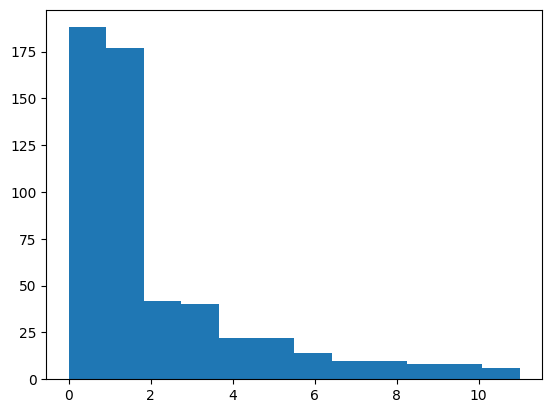

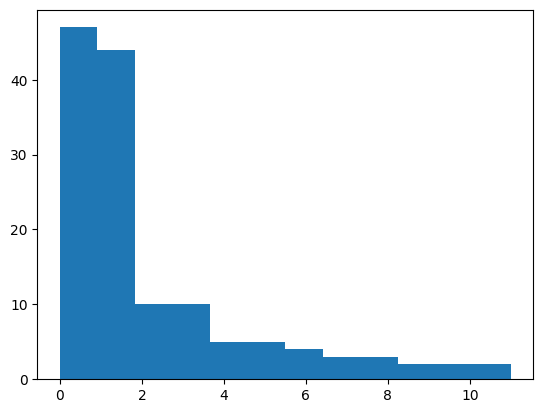

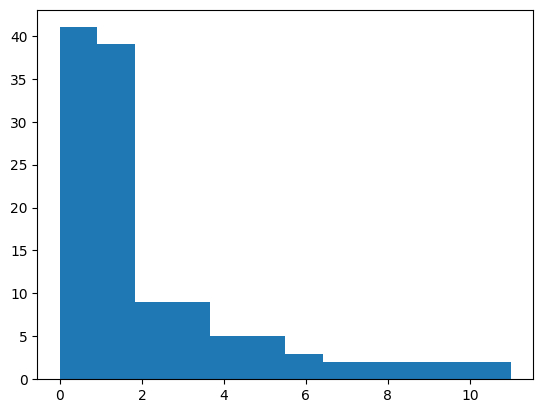

In [35]:
plt.hist(target_train, bins=12)
plt.show()
plt.hist(target_val, bins=12)
plt.show()
plt.hist(target_test, bins=12)
plt.show()

–¥–∞–Ω–Ω—ã–µ —Ä–∞–∑–¥–µ–ª–µ–Ω—ã –ø—Ä–æ–ø–æ—Ä—Ü–∏–æ–Ω–∞–ª—å–Ω–æ –ø–æ –∫–∞–∂–¥–æ–º—É –∫–ª–∞—Å—Å—É, —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤ –Ω–µ –∏–∑–º–µ–Ω–∏–ª–æ—Å—å.

### –í—ã–±–æ—Ä –º–æ–¥–µ–ª–∏

–ü—Ä–∏ –¥–∞–ª—å–Ω–µ–π—à–µ–º –≤—ã–±–æ—Ä–µ –º–æ–¥–µ–ª–µ–π –±—É–¥–µ–º —Å–ª–µ–¥–æ–≤–∞—Ç—å —Ç–∞–∫–æ–º—É –ø–ª–∞–Ω—É.
–ò–∑–≤–ª–µ—á–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –∏–∑ —Ç–µ–∫—Å—Ç–∞ –¥–≤—É–º—è —Å–ø–æ—Å–æ–±–∞–º–∏.  
1. –ü—Ä–∏–º–µ–Ω–∏–º TFIDF
2. –ü—Ä–∏–º–µ–Ω–∏–º –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—ã–π BERT –∏ –≤–æ–∑—å–º–µ–º —ç–º–µ–±–µ–¥–∏–Ω–≥ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –Ω–∞ –ø–æ—Å–ª–µ–¥–Ω–µ–º —Å–ª–æ–µ
3. –°–æ–∂–º–µ–º –≤ PCA
4. –ü–µ—Ä–µ–¥–∞–¥–∏–º –≤ LogReg –∏–ª–∏ Catboost

–û—Ü–µ–Ω–∏–≤–∞–µ–º –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–µ–π –±—É–¥–µ–º –æ—Ü–µ–Ω–∏–≤–∞—Ç—å –∏—Å–ø–æ–ª—å–∑—É—è f1-macro.  
–≠—Ç–∞ –º–µ—Ç—Ä–∏–∫–∞ —Ä–∞–≤–Ω–æ—Ü–µ–Ω–Ω–æ —É—á–∏—Ç—ã–≤–∞–µ—Ç –∫–ª–∞—Å—Å—ã, –ø–æ—ç—Ç–æ–º—É –æ—à–∏–±–∫–∏ –≤ –º–∏–Ω–æ—Ä–Ω—ã—Ö –∫–ª–∞—Å—Å–∞—Ö –±—É–¥—É—Ç "—Å—Ç–æ–∏—Ç—å –¥–æ—Ä–æ–≥–æ".

In [36]:
if torch.cuda.is_available() == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

–í –∫–∞—á–µ—Å—Ç–≤–µ –º–æ–¥–µ–ª–∏ –¥–ª—è —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏–∏ –≤–æ–∑—å–º–µ–º ProsusAI/finbert, –æ–±—É—á–µ–Ω–Ω—É—é –Ω–∞ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ —ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏—Ö –Ω–æ–≤–æ—Å—Ç–µ–π.  
https://huggingface.co/ProsusAI/finbert  

–ò–¥–µ—è –≤ —Ç–æ–º, —á—Ç–æ TFIDF –¥–æ–ª–∂–µ–Ω –¥–∞—Ç—å –Ω–∞–º –ø–æ–Ω–∏–º–∞–Ω–∏–µ –æ —Å–æ—Å—Ç–∞–≤–µ —Ç–µ–∫—Å—Ç–∞, –∞ BERT –¥–æ–±–∞–≤–∏—Ç –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –æ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏.

In [37]:
HF = 'ProsusAI/finbert'

tokenizer = AutoTokenizer.from_pretrained(HF, do_lower_case=True)

model = AutoModel.from_pretrained(HF)
model.to(device)

pca_model = PCA(random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=38000, ngram_range=(1, 4))

scores = []

cv_stratified = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

logit = LogisticRegression(class_weight='balanced',
                           max_iter=150,
                           C=1,
                           solver='lbfgs',
                           multi_class='multinomial',
                           random_state=42,
                           n_jobs=4)

–¢.–∫. –¥–∞–Ω–Ω—ã–µ –∏–º–µ—é—Ç —Å–∏–ª—å–Ω—ã–π –¥–∏—Å–±–∞–ª–∞–Ω—Å –∏ –ø—Ä–∏ —ç—Ç–æ–º –≤—ã–±–æ—Ä–∫–∞ –Ω–µ–±–æ–ª—å—à–∞—è, —Ç–æ –≤–æ–∑—å–º–µ–º 7 —Å–ø–ª–∏—Ç–æ–≤ –¥–∞–Ω–Ω—ã—Ö, —á—Ç–æ–±—ã –ª—É—á—à–µ –æ—Ü–µ–Ω–∏—Ç—å –∫–∞—á–µ—Å—Ç–≤–æ.

### –ù–∞ –∏—Å—Ö–æ–¥–Ω—ã—Ö (–Ω–µ–æ—á–∏—â–µ–Ω–Ω—ã—Ö) –¥–∞–Ω–Ω—ã—Ö

–û—Ü–µ–Ω–∏–º –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏ –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –Ω–∞ **–∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏** –æ–±—É—á–∞—é—â–µ–π+–≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ **—Å TF-IDF** –∏ **–±–µ–∑ BERT**.

In [ ]:
def train_model(logit, pca, tfidf, tokenizer_bert, model_bert, cv_stratified, device):
  model_out = []
  scores = []
  pca_out = []
  tfidf_out = []

  for index_train, index_val in cv_stratified.split(train_val, target_train_val):

      X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline(train_val.values,
                                                                    target_train_val,
                                                                    tokenizer_bert=tokenizer,
                                                                    model_bert=model,
                                                                    pca=pca_model,
                                                                    tfidf=vectorizer,
                                                                    index_train=index_train,
                                                                    index_val=index_val,
                                                                    device=device)


      logit.fit(X_train, y_train)
      y_pred = logit.predict(X_val)
      score = f1_score(y_val, y_pred, average='macro')


      scores_wo_bert.append(score)
      model_out = logit
      pca_out = pca
      tfidf_out = tfidf

  print(f'mean_score: {np.mean(scores_wo_bert)}')
  print(f'mean_score: {np.std(scores_wo_bert)}')

  return model_out, pca_out, tfidf_out, scores_wo_bert

In [ ]:
model_wo_bert, pca_wo_bert, tfidf_wo_bert, scores_wo_bert = train_model(logit = LogisticRegression(class_weight='balanced',
                                                                              max_iter=150,
                                                                              C=1,
                                                                              solver='lbfgs',
                                                                              multi_class='multinomial',
                                                                              random_state=42,
                                                                              n_jobs=4),
                                                                        pca = PCA(random_state=42),
                                                                        tfidf = TfidfVectorizer(stop_words='english', lowercase=True, max_features=38000, ngram_range=(1, 4)),
                                                                        tokenizer_bert = AutoTokenizer.from_pretrained(HF, do_lower_case=True),
                                                                        model_bert = AutoModel.from_pretrained(HF).to(device),
                                                                        cv_stratified = StratifiedKFold(n_splits=7, shuffle=True, random_state=42),
                                                                        device=device)

In [38]:
model_wo_bert = []
scores_wo_bert = []
pca_wo_bert = []
tfidf_wo_bert = []

for index_train, index_val in cv_stratified.split(train_val, target_train_val):
    X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline(train_val.values,
                                                                  target_train_val,
                                                                  tokenizer_bert=tokenizer,
                                                                  model_bert=model,
                                                                  pca=pca_model,
                                                                  tfidf=vectorizer,
                                                                  index_train=index_train,
                                                                  index_val=index_val,
                                                                  device=device)


    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    model_wo_bert.append(logit)
    scores_wo_bert.append(score)
    pca_wo_bert.append(pca)
    tfidf_wo_bert.append(tfidf)

print(f'mean_score: {np.mean(scores_wo_bert)}')
print(f'mean_score: {np.std(scores_wo_bert)}')


mean_score: 0.5401048260937618
mean_score: 0.08221644758170096


–û—Ü–µ–Ω–∏–º –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏ –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –Ω–∞ **–∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏** –æ–±—É—á–∞—é—â–µ–π+–≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ **—Å TF-IDF** –∏ **—Å BERT**.

In [39]:
model_w_bert = []
scores_w_bert = []
pca_w_bert = []
tfidf_w_bert = []

for index_train, index_val in cv_stratified.split(train_val, target_train_val):
    X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline(train_val.values,
                                                                  target_train_val,
                                                                  tokenizer_bert=tokenizer,
                                                                  model_bert=model,
                                                                  pca=pca_model,
                                                                  tfidf=vectorizer,
                                                                  index_train=index_train,
                                                                  index_val=index_val,
                                                                  bert=True,
                                                                  device=device)

    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    model_w_bert.append(logit)
    scores_w_bert.append(score)
    pca_w_bert.append(pca)
    tfidf_w_bert.append(tfidf)

print(f'mean_score: {np.mean(scores_w_bert)}')
print(f'std_score: {np.std(scores_w_bert)}')



mean_score: 0.47072828036799735
std_score: 0.08781478791291004


### –ù–∞ –æ—á–∏—â–µ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö

–û—Ü–µ–Ω–∏–º –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏ –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –Ω–∞ **–∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏** –æ–±—É—á–∞—é—â–µ–π+–≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ **—Å TF-IDF** –∏ –±–µ–∑ **BERT**.

In [40]:
model_wo_bert_clean = []
scores_wo_bert_clean = []
pca_wo_bert_clean = []
tfidf_wo_bert_clean = []

for index_train, index_val in cv_stratified.split(train_val_clean, target_train_val_clean):
    X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline(train_val_clean.values,
                                                                  target_train_val_clean,
                                                                  tokenizer_bert=tokenizer,
                                                                  model_bert=model,
                                                                  pca=pca_model,
                                                                  tfidf=vectorizer,
                                                                  index_train=index_train,
                                                                  index_val=index_val,
                                                                  device=device)


    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    model_wo_bert_clean.append(logit)
    scores_wo_bert_clean.append(score)
    pca_wo_bert_clean.append(pca)
    tfidf_wo_bert_clean.append(tfidf)

print(f'mean_score: {np.mean(scores_wo_bert_clean)}')
print(f'mean_score: {np.std(scores_wo_bert_clean)}')


mean_score: 0.4579885729291037
mean_score: 0.08862538109978872


–û—Ü–µ–Ω–∏–º –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏ –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –Ω–∞ **–∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏** –æ–±—É—á–∞—é—â–µ–π+–≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ **—Å TF-IDF** –∏ **—Å BERT**.

In [41]:
model_w_bert_clean = []
scores_w_bert_clean = []
pca_w_bert_clean = []
tfidf_w_bert_clean = []

for index_train, index_val in cv_stratified.split(train_val_clean, target_train_val_clean):

    X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline(train_val_clean.values,
                                                                  target_train_val_clean,
                                                                  tokenizer_bert=tokenizer,
                                                                  model_bert=model,
                                                                  pca=pca_model,
                                                                  tfidf=vectorizer,
                                                                  index_train=index_train,
                                                                  index_val=index_val,
                                                                  bert=True,
                                                                  device=device)


    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    model_w_bert_clean.append(logit)
    scores_w_bert_clean.append(score)
    pca_w_bert_clean.append(pca)
    tfidf_w_bert_clean.append(tfidf)

print(f'mean_score: {np.mean(scores_w_bert_clean)}')
print(f'mean_score: {np.std(scores_w_bert_clean)}')

mean_score: 0.424441661060646
mean_score: 0.08449825488305704


–ö–∞–∫ –≤–∏–¥–∏–º, –º–æ–¥–µ–ª–∏ –æ–±—É—á–µ–Ω–Ω—ã–µ –Ω–∞ –æ—á–∏—â–µ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç —Ö—É–∂–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã, —á–µ–º "—Å—ã—Ä—ã–µ".

–í –¥–∞–ª—å–Ω–µ–π—à–µ–º –±—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –º–æ–¥–µ–ª–∏ –æ–±—É—á–µ–Ω–Ω—ã–µ –Ω–∞ —Å—ã—Ä—ã—Ö –¥–∞–Ω–Ω—ã—Ö.



–û—Ü–µ–Ω–∏–º –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏ –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –Ω–∞ **–æ–±—É—á–∞—é—â–µ–π –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π** –≤—ã–±–æ—Ä–∫–µ **—Å TF-IDF** –∏ **–±–µ–∑ BERT**.

mean_score: 0.43966262747863877
              precision    recall  f1-score   support

           0       0.64      0.57      0.61        47
           1       0.75      0.89      0.81        44
           2       0.36      0.40      0.38        10
           3       0.29      0.40      0.33        10
           4       0.83      1.00      0.91         5
           5       0.71      1.00      0.83         5
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         3
           8       0.50      0.33      0.40         3
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2

    accuracy                           0.64       137
   macro avg       0.42      0.47      0.44       137
weighted avg       0.59      0.64      0.61       137



<Axes: >

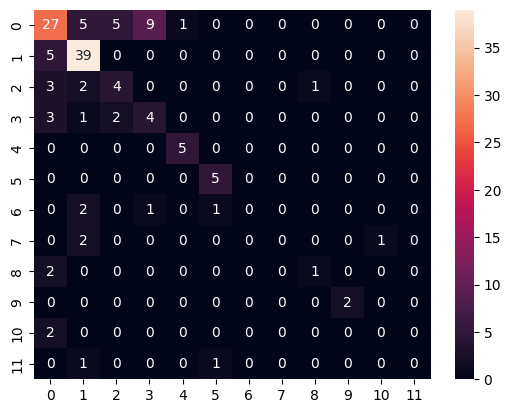

In [42]:
scores_full = []
pred_prob_full = []

X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline((train, val),
                                                              (target_train, target_val),
                                                              tokenizer_bert=tokenizer,
                                                              model_bert=model,
                                                              pca=pca_model,
                                                              tfidf=vectorizer,
                                                              index_train=None,
                                                              index_val=None,
                                                              bert=False,
                                                              cv=False)

logit.fit(X_train, y_train)
y_pred = logit.predict(X_val)
y_pred_prob = logit.predict_proba(X_val)
score = f1_score(y_val, y_pred, average='macro')

scores_full.append(score)
pred_prob_full.append(y_pred_prob)
model_full = deepcopy(logit)
pca_full = deepcopy(pca)
tfidf_full = deepcopy(tfidf)

print(f'mean_score: {np.mean(scores_full)}')
print(classification_report(y_val, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)


–û—Ü–µ–Ω–∏–º –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏ –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –Ω–∞ **–æ–±—É—á–∞—é—â–µ–π –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π** –≤—ã–±–æ—Ä–∫–∏ **—Å TF-IDF** –∏ **—Å BERT**.

mean_score: 0.36139699367253547
              precision    recall  f1-score   support

           0       0.48      0.26      0.33        47
           1       0.59      0.59      0.59        44
           2       0.33      0.30      0.32        10
           3       0.17      0.70      0.27        10
           4       1.00      0.80      0.89         5
           5       0.40      0.80      0.53         5
           6       1.00      0.25      0.40         4
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2

    accuracy                           0.43       137
   macro avg       0.41      0.39      0.36       137
weighted avg       0.49      0.43      0.43       137



<Axes: >

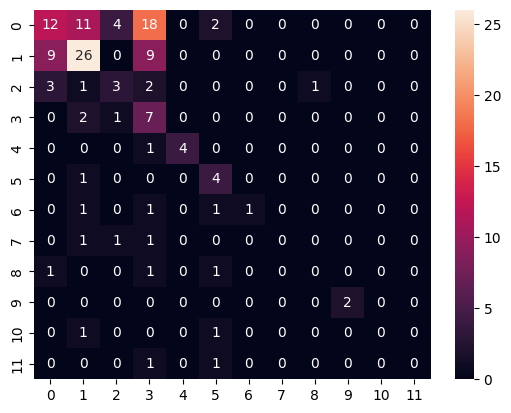

In [43]:
scores_full_w_bert = []
pred_prob_full_w_bert = []

X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline((train, val),
                                                              (target_train, target_val),
                                                              tokenizer_bert = tokenizer,
                                                              model_bert = model,
                                                              pca = pca_model,
                                                              tfidf = vectorizer,
                                                              index_train = index_train,
                                                              index_val = index_val,
                                                              bert=True,
                                                              cv=False,
                                                              device=device)

logit.fit(X_train, y_train)
y_pred = logit.predict(X_val)
y_pred_prob = logit.predict_proba(X_val)
score = f1_score(y_val, y_pred, average='macro')

scores_full_w_bert.append(score)
pred_prob_full_w_bert.append(y_pred_prob)
model_full_w_bert = deepcopy(logit)
pca_full_w_bert = deepcopy(pca)
tfidf_full_w_bert = deepcopy(tfidf)

print(f'mean_score: {np.mean(scores_full_w_bert)}')
print(classification_report(y_val, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)


### –í—ã–≤–æ–¥—ã

–ù–∞ —Å—ã—Ä—ã—Ö –¥–∞–Ω–Ω—ã—Ö –º–æ–¥–µ–ª—å –ø–æ–∫–∞–∑–∞–ª–∞ –ª—É—á—à–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç, —á–µ–º –Ω–∞ –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã—Ö.   


–°—É–¥—è –ø–æ –º–∞—Ç—Ä–∏—Ü–µ –æ—à–∏–±–æ–∫, –ª–∏–Ω–µ–π–Ω–∞—è –º–æ–¥–µ–ª—å —Ö–æ—Ä–æ—à–æ –æ–ø—Ä–µ–¥–µ–ª—è–µ—Ç –∫–ª–∞—Å—Å—ã —Å –±–æ–ª—å—à–∏–º–∏ —á–∏—Å–ª–æ–º –æ–±—ä–µ–∫—Ç–æ–≤, —Ö—É–∂–µ –∫–ª–∞—Å—Å—ã —Å –º–∞–ª–µ–Ω—å–∫–∏–º —á–∏—Å–ª–æ–º –æ–±—ä–µ–∫—Ç–æ–≤.

–ü—Ä–∏ —ç—Ç–æ–º –∏–∑-–∑–∞ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è **f1-macro** –≤ –∫–∞—á–µ—Å—Ç–≤–µ —Ü–µ–ª–µ–≤–æ–π –º–µ—Ç—Ä–∏–∫–∏ –ø–æ–ª—É—á–∞–µ–º —Å–∏–ª—å–Ω—ã–π —à—Ç—Ä–∞—Ñ –∑–∞ –æ—à–∏–±–∫–∏ –≤ –º–∏–Ω–æ—Ä–Ω—ã—Ö –∫–ª–∞—Å—Å–∞—Ö, –≤ —Ç–æ –≤—Ä–µ–º—è –∫–∞–∫ –æ—à–∏–±–∫–∏ –≤ –º–∞–∂–æ—Ä–Ω—ã—Ö –∫–ª–∞—Å—Å–∞—Ö –º–µ–Ω–µ–µ –∫—Ä–∏—Ç–∏—á–Ω—ã.


–ö—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—è –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç, —á—Ç–æ –º–æ–¥–µ–ª—å —É –∫–æ—Ç–æ—Ä–æ–π –¥–∞—Ç–∞—Å–µ—Ç –≤–∫–ª—é—á–∞–µ—Ç—Å—è –≤ —Å–µ–±—è TF-IDF –∏–º–µ—Ç —Å—Ä–µ–¥–Ω–∏–π —Å–∫–æ—Ä –≤—ã—à–µ –º–æ–¥–µ–ª–∏ –æ–±—É—á–µ–Ω–æ–π –Ω–∞ TFIDF –∏ BERT.


### CatBoost

LogReg –ø–æ–∫–∞–∑–∞–ª–∞ —Ö–æ—Ä–æ—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç –Ω–∞ TF-IDF + EMB.  

–ì–∏–ø–æ—Ç–µ–∑–∞:
- –ë—É—Å—Ç–∏–Ω–≥–æ–º –º–æ–∂–Ω–æ –≤—ã–∂–∞—Ç—å –±–æ–ª—å—à–µ –ø–æ–ª—å–∑—ã –∏–∑ –¥–∞–Ω–Ω—ã—Ö, –Ω–∞–π—Ç–∏ –Ω–æ–≤—ã–µ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏.  

–ü—Ä–æ–±–ª–µ–º—ã:
- –ë—É—Å—Ç–∏–Ω–≥–∏ –Ω–µ –≤—Å–µ–≥–¥–∞ —Ö–æ—Ä–æ—à–æ —Ä–∞–±–æ—Ç–∞—é—Ç, –µ—Å–ª–∏ –µ—Å—Ç—å —Å–∏–ª—å–Ω–∞—è –ª–∏–Ω–µ–π–Ω–∞—è —Å–≤—è–∑—å
- –í –±—É—Å—Ç–∏–Ω–≥–∏ –Ω–∞–¥–æ –∞–∫–∫—É—Ä–∞—Ç–Ω–æ –Ω–∞—Å—Ç—Ä–∞–∏–≤–∞—Ç—å –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã

–†–µ—à–µ–Ω–∏–µ:
- –í–æ–∑—å–º–µ–º CatBoost, –æ–Ω "–∏–∑ –∫–æ—Ä–æ–±–∫–∏" –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç —Ö–æ—Ä–æ—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã, –µ—Å–ª–∏ –±—É–¥–µ—Ç –ø–æ—Ö–æ–∂–µ –Ω–∞ –ª—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç, —á–µ–º LogReg, —Ç–æ –º–æ–∂–Ω–æ –ø–æ–¥–æ–±—Ä–∞—Ç—å –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã, –µ—Å–ª–∏ –Ω–µ—Ç, —Ç–æ –Ω–µ—Ç.

In [44]:
cb = CatBoostClassifier(task_type="GPU",
                        auto_class_weights='Balanced',
                        loss_function='MultiClass',
                        verbose=True)

–û—Ü–µ–Ω–∏–º –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏ Catboost –Ω–∞ **–∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏** –æ–±—É—á–∞—é—â–µ–π+–≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ **—Å TF-IDF** –∏ **—Å BERT**.

In [48]:
cb_model_w_bert = []
cb_scores_w_bert = []
for index_train, index_val in cv_stratified.split(train_val, target_train_val):
    X_train, X_val, y_train, y_val, _, _ = dataset_pipeline(train_val.values,
                                                      target_train_val,
                                                      tokenizer_bert=tokenizer,
                                                      model_bert=model,
                                                      pca=pca_model,
                                                      tfidf=vectorizer,
                                                      index_train=index_train,
                                                      index_val=index_val,
                                                      bert=True,
                                                      cv=True,
                                                      device=device)

    text_pool = Pool(data=X_train, label=y_train)
    eval_pool = Pool(data=X_val, label=y_val)

    cb.fit(text_pool, eval_set=eval_pool, verbose=False)
    y_pred = cb.predict(eval_pool)
    score = f1_score(y_val, y_pred, average='macro')

    cb_scores_w_bert.append(score)
    cb_model_w_bert.append(cb)

print(np.mean(cb_scores_w_bert))
print(np.std(cb_scores_w_bert))


0.40763424436528484
0.08224868928364143


In [49]:
cb_scores_w_bert

[0.4297771672771673,
 0.2708763918929744,
 0.40074131658638706,
 0.5050856550856552,
 0.38475724991854027,
 0.5232744107744108,
 0.33892751902185864]

–û—Ü–µ–Ω–∏–º –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏ Catboost –Ω–∞ **–æ–±—É—á–∞—é—â–µ–π –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π** –≤—ã–±–æ—Ä–∫–∏ **—Å TF-IDF** –∏ **—Å BERT**.

0.3223864226069727
              precision    recall  f1-score   support

           0       0.54      0.40      0.46        47
           1       0.68      0.77      0.72        44
           2       0.14      0.20      0.17        10
           3       0.17      0.20      0.18        10
           4       0.80      0.80      0.80         5
           5       0.40      0.80      0.53         5
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2

    accuracy                           0.49       137
   macro avg       0.31      0.35      0.32       137
weighted avg       0.49      0.49      0.48       137



<Axes: >

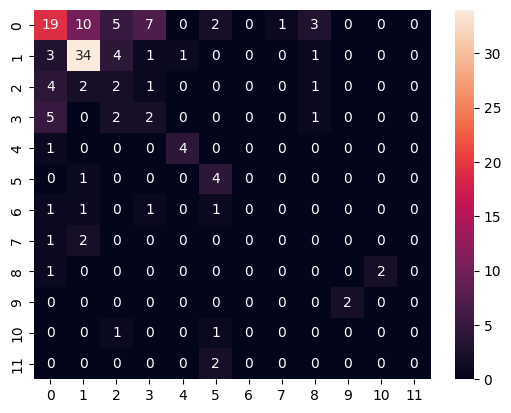

In [50]:
cb_scores_full = []
cb_model_full = []

X_train, X_val, y_train, y_val, _, _ = dataset_pipeline((train, val),
                                                        (target_train, target_val),
                                                        tokenizer_bert=tokenizer,
                                                        model_bert=model,
                                                        pca=pca_model,
                                                        tfidf=vectorizer,
                                                        index_train=index_train,
                                                        index_val=index_val,
                                                        bert=True,
                                                        cv=False,
                                                        device=device)

text_pool = Pool(data=X_train, label=y_train)
eval_pool = Pool(data=X_val, label=y_val)

cb.fit(text_pool, eval_set=eval_pool, verbose=False)
y_pred = cb.predict(eval_pool)
score = f1_score(y_val, y_pred, average='macro')

cb_scores_full.append(score)
cb_model_full.append(cb)

print(np.mean(cb_scores_full))
print(classification_report(y_val, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)

In [57]:
cb_scores_full

[0.3223864226069727]

Catboost —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º TFIDF –∏ CV –ø–æ–∫–∞–∑–∞–ª –ª—É—á—à–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç, —á–µ–º c TFIDF –∏ BERT.  
–ù–æ –ª—É—á—à–∞—è –º–µ—Ç—Ä–∏–∫–∞ CatBoost —Ö—É–∂–µ LogReg  

–û—Å—Ç–∞–Ω–æ–≤–∏–º —Å–≤–æ–π –≤—ã–±–æ—Ä–∞ –Ω–∞ LogReg –Ω–∞ —Å—ã—Ä—ã—Ö –¥–∞–Ω–Ω—ã—Ö

### BERT

–¢.–∫. –¥–∞—Ç–∞—Å–µ—Ç –º–∞–ª–µ–Ω—å–∫–∏–π, –∫–ª–∞—Å—Å–æ–≤ –º–Ω–æ–≥–æ, –¥–∏—Å–±–∞–ª–∞–Ω—Å –±–æ–ª—å—à–æ–π, —Ç–æ –º–æ–∂–Ω–æ –ø—Ä–µ–¥–ø–æ–ª–æ–∂–∏—Ç—å —Å–ª–µ–¥—É—é—â–∏–µ –≥–∏–ø–æ—Ç–µ–∑—ã, –≤ –∫–æ—Ç–æ—Ä—ã—Ö BERT –º–æ–∂–µ—Ç –±—ã—Ç—å –ø–æ–ª–µ–∑–µ–Ω:  
1. –í –∫–∞—á–µ—Å—Ç–≤–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –º–æ–¥–µ–ª–∏ (—Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω–æ —Ä–∞–Ω–µ–µ —Å –ª–∏–Ω–µ–π–Ω–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–µ–π, –ø–æ–∫–∞–∑–∞–ª–æ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å)
2. –°–∞–º–æ—Å—Ç–æ—è—Ç–µ–ª—å–Ω–∞—è –º–æ–¥–µ–ª—å, –∫–æ—Ç–æ—Ä—É—é –º–æ–∂–Ω–æ –¥–æ–æ–±—É—á–∏—Ç—å –Ω–∞ –¥–∞–Ω–Ω—ã—Ö –∏ –ø–æ–ª—É—á–∏—Ç—å –æ–¥–Ω—É –º–æ–¥–µ–ª—å —Å–ø–æ—Å–æ–±–Ω—É—é —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ –æ–ø—Ä–µ–¥–µ–ª—è—Ç—å –∫–ª–∞—Å—Å—ã.  
–¢—É—Ç –ø—Ä–æ–±–ª–µ–º –Ω–µ—Å–∫–æ–ª—å–∫–æ:
- –ú–æ–¥–µ–ª—å —Ç—Ä–µ–±—É–µ—Ç –≤—Å–µ-—Ç–∞–∫–∏ –±–æ–ª—å—à—É—é –≤—ã–±–æ—Ä–∫—É –¥–ª—è –¥–æ–æ–±—É—á–µ–Ω–∏—è, —á—Ç–æ–±—ã –ø–æ–∫–∞–∑–∞—Ç—å –∑–Ω–∞—á–∏—Ç–µ–Ω–ª—å–Ω—ã–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç. –ù–∞ –º–∞–ª—å–µ–Ω–∫–æ–º –∫–æ–ª-–≤–µ –¥–∞–Ω–Ω—ã—Ö —Å–ª–æ–∂–Ω—ã–µ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ–Ω–∞ –ø—Ä–æ—Å—Ç–æ –Ω–µ —Å–º–æ–∂–µ—Ç –¥–æ—Å—Ç–∞—Ç—å.
- –ú–æ–¥–µ–ª—å —Å–∫–æ—Ä–µ–µ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∞ –Ω–∞ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è "—Å–º—ã—Å–ª–∞" —Ç–µ–∫—Å—Ç–∞, –Ω–µ–∂–µ–ª–∏ –Ω–∞ —Å—Ö–æ–∂–µ—Å—Ç—å –ø–æ —Å–ª–æ–≤–∞–º. –ê —Å—É–¥—è –ø–æ –¥–∞—Ç–∞—Å–µ—Ç—É –∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º TF-IDF, –¥–∞ –∏ –≤ —Ü–µ–ª–æ–º –∑–∞–¥–∞—á–∏ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–æ–≤, —á–∞—Å—Ç–æ—Ç–Ω–æ—Å—Ç—å —Å–ª–æ–≤ —è–≤–ª—è–µ—Ç—Å—è —Ö–æ—Ä–æ—à–∏–º –ø—Ä–µ–¥–∏–∫—Ç–æ—Ä–æ–º –¥–ª—è –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–∞ –∑–∞–¥–∞—á–∏.  
3. –ß—Ç–æ —É—Å–ø–µ–ª –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å?  
- –ü–æ–ø—ã—Ç–∫–∏ –æ–±—É—á–∏—Ç—å —Å–∞–º–æ—Å—Ç–æ—è—Ç–µ–ª—å–Ω—É—é –º–æ–¥–µ–ª—å –Ω–µ –ø–æ–∫–∞–∑–∞–ª–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –ø—Ä–µ–≤—ã—à–∞—é—â–∏—Ö LogReg.  –ü—Ä–æ–±–æ–≤–∞–ª —Ä–∞–∑–Ω—ã–µ –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—ã–µ –º–æ–¥–µ–ª–∏, –Ω–∞–¥—Å—Ç—Ä–∞–∏–≤–∞–ª "–≥–æ–ª–æ–≤—ã", –¥–æ–æ–±—É—á–∞–ª –±–ª–æ–∫–∏ –≤–Ω–∏–º–∞–Ω–∏—è, –ø–æ—Ç—Ä–∞—Ç–∏–ª –º–Ω–æ–≥–æ —á–∞—Å–æ–≤ GPU –≤ Colab, –Ω–æ –ª—É—á—à–µ LogReg –Ω–µ –ø–æ–ª—É—á–∏–ª–æ—Å—å —Å–¥–µ–ª–∞—Ç—å.  

**–†–µ—à–µ–Ω–∏–µ**  
–ü–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å –æ–±—ä–µ–¥–∏–Ω–∏—Ç—å —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã LogReg –æ–±—É—á–µ–Ω–Ω–æ–π –Ω–∞ TFIDF –∏ BERT, –∏—Å–ø–æ–ª—å–∑—É—è –≤–∑–≤–µ—à–µ–Ω–Ω—É—é —Å—É–º–º—É —É–≤–µ—Ä–µ–Ω–Ω–æ—Å—Ç–µ (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–µ–π) –º–æ–¥–µ–ª–µ–π.  
–°–º—ã—Å–ª –≤ —Ç–æ–º, —á—Ç–æ TF-IDF –æ—Ä–∏–µ–Ω—Ç–∏—Ä—É–µ—Ç—Å—è –Ω–∞ –∫–æ–Ω—Å—Ç—Ä—É–∫—Ü–∏—é —Ç–µ–∫—Å—Ç–∞, –∞ BERT –Ω–∞ "—Å–º—ã—Å–ª–∞" —Ç–µ–∫—Å—Ç–∞. (–æ—á–µ–Ω—å —É–ø—Ä–æ—â—ë–Ω–Ω–æ)

–ü—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–∞—è –º–æ–¥–µ–ª—å BERT

In [58]:
HF = 'ProsusAI/finbert'

–ü–æ–¥–≥–æ—Ç–æ–≤–∏–º –¥–∞–Ω–Ω—ã–µ   

–¢.–∫. CV –Ω–∞ —Ç–∞–∫–∏—Ö –º–æ–¥–µ–ª—è—Ö –ø—Ä–æ–≤–æ–¥–∏—Ç—å —Å–ª–∏—à–∫–æ–º —Ç—Ä—É–¥–æ–∑–∞—Ç—Ä–∞—Ç–Ω–æ –∏ –Ω–µ –æ—Å–æ–±–æ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ, —Ç–æ –¥–æ–æ–±—É—á–∏–º –º–æ–¥–µ–ª—å –Ω–∞ train –∏ val.

In [59]:
tokenizer = AutoTokenizer.from_pretrained(HF, do_lower_case=True)
train_dataloader, val_dataloader, test_dataloader = dataset(train, val, test, tokenizer, target_train, target_val, target_test, batch_size=50)

In [60]:
# —Å–±–æ—Ä –∏ –æ—Ç—á–∏—Å—Ç–∫–∞ –º—É—Å–æ—Ä–∞ –ø–µ—Ä–µ–¥ –æ–±—É—á–µ–Ω–∏–µ–º
import gc
gc.collect()
torch.cuda.empty_cache()

In [61]:
# PATH_MODEL='./data/bert_multiclass1.pt'
# epochs = 50

# model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train_val)), ignore_mismatched_sizes=True)
# model.to(device)

# optimizer = AdamW(model.parameters(), lr=1e-5)

# total_steps = len(train_dataloader) * epochs
# scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=3, num_training_steps=total_steps)

# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(target_train), y=target_train)
# class_weights = (class_weights / class_weights.sum())
# class_weights = torch.tensor(class_weights).float().to(device)

# criterion = nn.CrossEntropyLoss(weight=class_weights)

# _, _, _ = trainer_pipeline(epochs=epochs,
#                 PATH_MODEL=PATH_MODEL,
#                 model = model,
#                 HF = HF,
#                 optimizer = optimizer,
#                 scheduler = scheduler,
#                 criterion = criterion,
#                 train_dataloader = train_dataloader,
#                 val_dataloader = val_dataloader,
#                 device=device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.25      0.02      0.04        47
           1       0.58      0.75      0.65        44
           2       0.30      0.30      0.30        10
           3       0.18      0.60      0.28        10
           4       0.50      0.80      0.62         5
           5       0.17      0.20      0.18         5
           6       0.17      0.25      0.20         4
           7       0.00      0.00      0.00         3
           8       0.33      0.67      0.44         3
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2

    accuracy                           0.37       137
   macro avg       0.21      0.30      0.23       137
weighted avg       0.34      0.37      0.31       137



<Axes: >

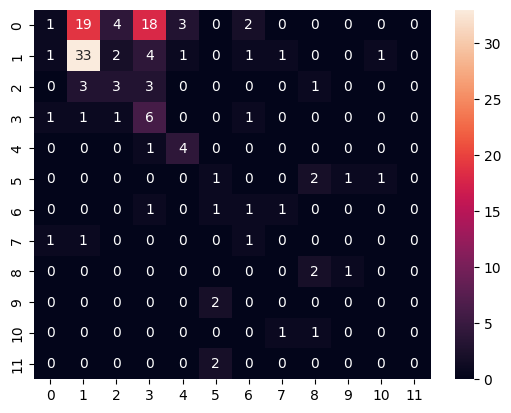

In [62]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(target_train), y=target_train)
class_weights = (class_weights / class_weights.sum())
class_weights = torch.tensor(class_weights).float().to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

PATH_MODEL='./data/bert_multiclass1.pt'
model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train)), ignore_mismatched_sizes=True)
model.load_state_dict(torch.load(PATH_MODEL, map_location=device))
model.to(device)
valid_loss, valid_pred, valid_labels = evaluate(model, criterion, val_dataloader, device=device)

print(classification_report(valid_labels, np.argmax(valid_pred, axis=1).flatten(), zero_division=0))
sns.heatmap(confusion_matrix(valid_labels, np.argmax(valid_pred, axis=1).flatten()), annot=True)

–≠—Ç–∞ –º–æ–¥–µ–ª—å –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –ª—É—á—à–∏–π —Å–∫–æ—Ä –Ω–∞ –º–µ–Ω—å—à–µ–º —Ä–∞–∑–º–µ—Ä–µ –±–∞—Ç—á–∞, –ø—Ä–∏—á–µ–º —Ä–∞–∑–ª–∏—á–∏–µ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ–µ.  

### BERT + TEXT GEN

–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –º–æ–¥–µ–ª–∏ –ø—Ä–∏ —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ –ø—Ä–∏ –ø–æ–º–æ—â–∏ –∞—É–≥—É–º–µ–Ω—Ç–∞—Ü–∏–∏.   
–ë—É–¥–µ—Ç –∑–∞–º–µ–Ω—è—Ç—å —Å–ª–æ–≤–∞ –Ω–∞ —Å–∏–Ω–æ–Ω–∏–º—ã.

In [63]:
aug = naw.SynonymAug(aug_src='wordnet')
unique, counts = np.unique(target_train, return_counts=True)

add_train = train.to_list()
add_target_train = list(target_train)

max_count = max(counts)

for idx, n in enumerate(unique):
  features_num = max_count - counts[idx]
  examples = np.random.choice(np.array(train.to_list())[target_train == n], features_num, replace=True)

  for sentance in examples:
    add_train.extend(aug.augment(sentance))
  add_target_train.extend([n]*features_num)

In [64]:
len(add_train)

2256

In [65]:
len(add_target_train)

2256

In [66]:
train_dataloader, val_dataloader, test_dataloader = dataset(add_train, val, test, tokenizer, add_target_train, target_val, target_test, batch_size=150)

In [67]:
# PATH_MODEL_BALANCED = 'bert_multiclass_balanced11.pt'
# epochs = 100

# model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train_val)), ignore_mismatched_sizes=True)

# optimizer = AdamW(model.parameters(), lr=1e-5)

# total_steps = len(train_dataloader) * epochs
# optimizer = AdamW(model.parameters(), lr=1e-5)

# scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=3, num_training_steps=total_steps)

# criterion = nn.CrossEntropyLoss()

# _, _, _ = trainer_pipeline(epochs=epochs,
#                           PATH_MODEL=PATH_MODEL,
#                           model = model,
#                           HF = HF,
#                           optimizer = optimizer,
#                           scheduler = scheduler,
#                           criterion = criterion,
#                           train_dataloader = train_dataloader,
#                           val_dataloader = val_dataloader,
#                           device=device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.74      0.60      0.66        47
           1       0.78      0.82      0.80        44
           2       0.56      0.50      0.53        10
           3       0.55      0.60      0.57        10
           4       0.62      1.00      0.77         5
           5       0.36      0.80      0.50         5
           6       0.50      0.50      0.50         4
           7       0.40      0.67      0.50         3
           8       0.50      0.33      0.40         3
           9       0.00      0.00      0.00         2
          10       0.33      0.50      0.40         2
          11       0.00      0.00      0.00         2

    accuracy                           0.66       137
   macro avg       0.45      0.53      0.47       137
weighted avg       0.66      0.66      0.65       137



<Axes: >

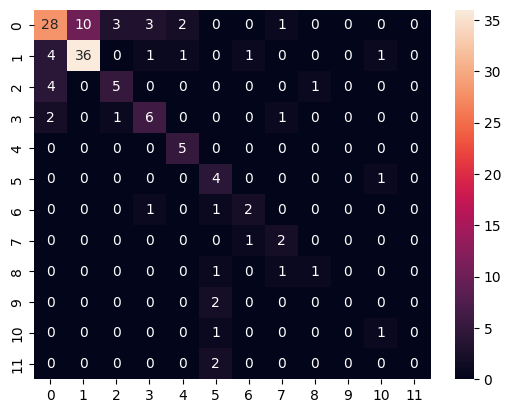

In [68]:
criterion = nn.CrossEntropyLoss()
PATH_MODEL_BALANCED = './data/bert_multiclass_balanced11.pt'

model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train)), ignore_mismatched_sizes=True)
model.load_state_dict(torch.load(PATH_MODEL_BALANCED, map_location=device))
model.to(device)
add_valid_loss, add_valid_pred, add_valid_labels = evaluate(model, criterion, val_dataloader, device=device)

print(classification_report(add_valid_labels, np.argmax(add_valid_pred, axis=1).flatten(), zero_division=0))
sns.heatmap(confusion_matrix(add_valid_labels, np.argmax(add_valid_pred, axis=1).flatten()), annot=True)

–ö–∞–∫ –≤–∏–¥–∏–º –º–æ–¥–µ–ª—å BERT –æ–±—É—á–µ–Ω–Ω–∞—è –Ω–∞ –∞—É–≥—É–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –ª—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å –º–æ–¥–µ–ª—å—é –∏—Å–ø–æ–ª—å–∑—É—é—â–µ–π –±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫—É —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å.

### Blending

–ü–æ–¥–±–µ—Ä–µ–º –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –¥–ª—è —Å–º–µ—à–∏–≤–∞–Ω–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –º–æ–¥–µ–ª–µ–π.  
–î–ª—è —ç—Ç–æ–≥–æ –≤–æ–∑—å–º–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è LogReg –º–æ–¥–µ–ª–∏ –æ–±—É—á–µ–Ω–Ω–æ–π —Ç–æ–ª—å–∫–æ –Ω–∞ TDIDF –∏ BERT –∏ –ø–æ–¥–±–µ—Ä–µ–º –∫–æ—ç—Ñ, –ø—Ä–∏ –∫–æ—Ç–æ—Ä–æ–æ–º –∏—Ö —Å—É–º–º–∞ –º–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è.  
( —Å–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ —ç—Ç–æ –Ω–µ —Å–∞–º—ã–π –æ–±—ä–µ–∫—Ç–∏—ã–Ω—ã–π —Å–ø–æ—Å–æ–± –ø–æ–¥–±–æ—Ä–∞, –º–æ–∂–Ω–æ –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ –∏ —Ç–ø.)

In [69]:
bert_pred = F.softmax(torch.tensor(add_valid_pred)).detach().cpu().numpy()

<ipython-input-69-78678ce0047d>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  bert_pred = F.softmax(torch.tensor(add_valid_pred)).detach().cpu().numpy()


In [70]:
lr_pred = pred_prob_full[0]

–ù–∞–π–¥–µ–º –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ø–æ—Ä–æ–≥ "trsh".  
–î–ª—è —ç—Ç–æ–≥–æ –≤—ã–±–µ—Ä–µ–º —Ç–∞–∫–æ–π –ø–æ—Ä–æ–≥, –ø—Ä–∏ –∫–æ—Ç–æ—Ä–æ–º —Å—Ä–µ–¥–Ω–µ–µ –≤–∑–≤–µ—à–µ–Ω–Ω–æ–µ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–µ–π –¥–∞–µ—Ç –º–∞–∫—Å–∏–º–∞–ª—å–Ω—É—é –º–µ—Ç—Ä–∏–∫—É f1-macro.

In [71]:
res_score = {}

for i in range(0, 100, 1):
  i = i / 100
  y_pred_blend = np.argmax(bert_pred * (1 - i) + lr_pred * i, axis=1)
  score = f1_score(target_val, y_pred_blend, average='macro')
  res_score[i] = score

for key, value in res_score.items():
  if value == max(res_score.values()):
    trsh = key
print(f'trsh: {trsh}')

trsh: 0.92


–°–º–µ—à–∞–µ–º –∏ –ø—Ä–µ–¥—Å–∫–∞–∂–µ–º

In [72]:
y_pred_blend = np.argmax(bert_pred*(1 - trsh) + lr_pred*trsh, axis=1)

              precision    recall  f1-score   support

           0       0.73      0.68      0.70        47
           1       0.89      0.89      0.89        44
           2       0.56      0.50      0.53        10
           3       0.47      0.70      0.56        10
           4       0.83      1.00      0.91         5
           5       0.56      1.00      0.71         5
           6       1.00      0.50      0.67         4
           7       1.00      0.67      0.80         3
           8       0.50      0.33      0.40         3
           9       1.00      1.00      1.00         2
          10       0.50      0.50      0.50         2
          11       0.00      0.00      0.00         2

    accuracy                           0.74       137
   macro avg       0.67      0.65      0.64       137
weighted avg       0.74      0.74      0.73       137



<Axes: >

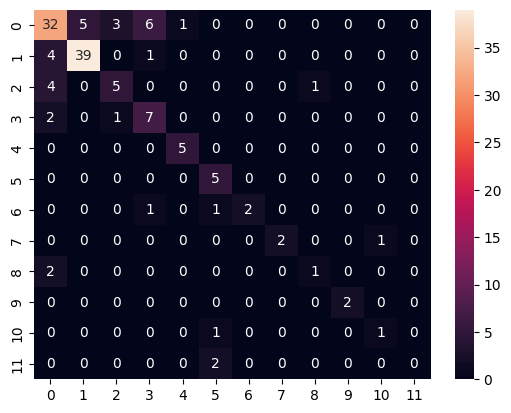

In [73]:
print(classification_report(target_val, y_pred_blend, zero_division=0))
sns.heatmap(confusion_matrix(target_val, y_pred_blend), annot=True)

–ö–∞–∫ –≤–∏–¥–∏–º —Å–º–µ—à–∏–≤–∞–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ —Ä–∞–±–æ—Ç—ã –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –∏ BERT –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –ø—Ä–µ–≤–æ—Å—Ö–æ–¥—è—â–∏–π –≤—Å–µ –ø—Ä–µ–¥—ã–¥—É—â–∏–µ –≤–∞—Ä–∏–∞–Ω—Ç—ã.  
–ü—Ä–æ—Ç–µ—Å—Ç–∏—Ä—É–µ–º –¥–∞–Ω–Ω—É—é –∫–æ–º–±–∏–Ω–∞—Ü–∏—é.

### Test

–í—ã—à–µ –º—ã —Å–¥–µ–ª–∞–ª–∏ –¥–≤–∞ –æ—Å–Ω–æ–≤–Ω—ã—Ö –≤—ã–≤–æ–¥–∞:  
1. LogReg —Å TFIDF –ø–æ–∫–∞–∑–∞–ª–∞ –ª—É—á—à–µ–µ –∫–∞—á–µ—Å—Ç–≤–æ.  
2. –°–º–µ—à–∏–≤–∞–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –ø—Ä–æ–≥–Ω–æ–∑–∞ LogReg –Ω–∞ TFIDF –∏ BERT –¥–æ–æ–±—É—á–µ–Ω–Ω–æ–≥–æ –Ω–∞ train –¥–∞–µ—Ç –º–∞–ª–µ–Ω—å–∫–∏–π, –Ω–æ –ø—Ä–∏—Ä–æ—Å—Ç –≤ –º–µ—Ç—Ä–∏–∫–µ.  

–ü—Ä–æ–≤–µ—Ä–∏–º –º–æ–¥–µ–ª—å –Ω–∞ –æ—Ç–ª–æ–∂–µ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ test

score: 0.6656178001807513
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        41
           1       0.72      0.87      0.79        39
           2       0.67      0.22      0.33         9
           3       0.64      0.78      0.70         9
           4       1.00      0.40      0.57         5
           5       1.00      1.00      1.00         5
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         2
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         2

    accuracy                           0.74       121
   macro avg       0.81      0.62      0.67       121
weighted avg       0.75      0.74      0.72       121



<Axes: >

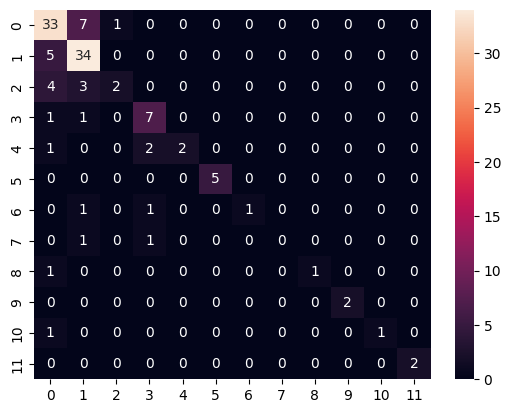

In [74]:
X_train, X_val, y_train, y_val, _, _ = dataset_pipeline(test,
                                                        target_test,
                                                        tokenizer_bert = AutoTokenizer.from_pretrained(HF, do_lower_case=True),
                                                        model_bert = AutoModel.from_pretrained(HF),
                                                        pca = pca_full,
                                                        tfidf = tfidf_full,
                                                        index_train = index_train,
                                                        index_val = index_val,
                                                        bert=False,
                                                        cv=False,
                                                        is_test=True,
                                                        device=device)

logit = model_full
y_pred = logit.predict(X_val)
y_pred_proba = logit.predict_proba(X_val)
score = f1_score(target_test, y_pred, average='macro')

print(f'score: {score}')
print(classification_report(target_test, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(target_test, y_pred), annot=True)


In [75]:
PATH_MODEL_BALANCED = './data/bert_multiclass_balanced11.pt'

model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train_val)), ignore_mismatched_sizes=True)
model.load_state_dict(torch.load(PATH_MODEL_BALANCED, map_location=device))
model.to(device)
model.eval()

criterion = nn.CrossEntropyLoss()

test_loss, test_pred, test_labels = evaluate(model, criterion, test_dataloader, device=device)
logist_softmax = F.softmax(torch.tensor(test_pred)).detach().cpu().numpy()

test_pred_concat = np.argmax(logist_softmax*(1 - trsh) + y_pred_proba*trsh, axis=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-75-d2c548af17d8>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logist_softmax = F.softmax(torch.tensor(test_pred)).detach().cpu().numpy()


              precision    recall  f1-score   support

           0       0.73      0.80      0.77        41
           1       0.77      0.87      0.82        39
           2       0.67      0.22      0.33         9
           3       0.82      1.00      0.90         9
           4       0.75      0.60      0.67         5
           5       1.00      1.00      1.00         5
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         2

    accuracy                           0.78       121
   macro avg       0.81      0.69      0.72       121
weighted avg       0.77      0.78      0.76       121



<Axes: >

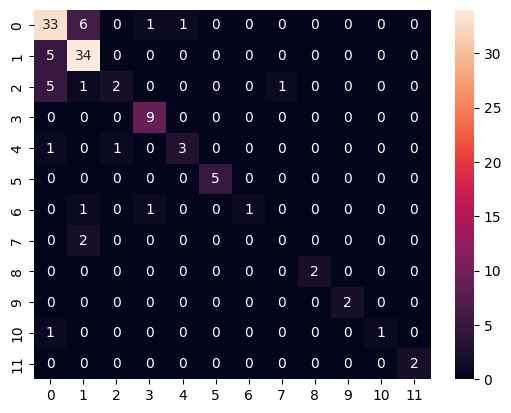

In [76]:
print(classification_report(test_labels, test_pred_concat, zero_division=0))
sns.heatmap(confusion_matrix(test_labels, test_pred_concat), annot=True)

–ü–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º —Ä–∞–±–æ—Ç—ã –º–æ–¥–µ–ª–∏ —É—á–µ—Ç–∞ –æ—Ü–µ–Ω–∫–∏ –∫–∞–∫ LR, —Ç–∞–∫ –∏ BERT –≤–∏–¥–∏–º, —á—Ç–æ —Å–æ–≤–º–µ—Å—Ç–Ω–∞—è –æ—Ü–µ–Ω–∫–∞ –ø—Ä–µ–≤–æ—Å—Ö–æ–¥–∏—Ç –æ–¥–∏–Ω—É—á–Ω—É—é LR.  

### Inference

In [79]:
lable2token

{'development, specified': 0,
 'partnership, non-crypto': 1,
 'development': 2,
 'announcement promise': 3,
 'start of burn/buyback': 4,
 'legal, negative': 5,
 'legal, positive': 6,
 'raise': 7,
 'exploit': 8,
 'negative': 9,
 'selling': 10,
 'ripple': 11}

In [81]:
text_to_classify = ["This is an example sentence for classification."]

PATH_MODEL_BALANCED = './data/bert_multiclass_balanced11.pt'
tokenizer = AutoTokenizer.from_pretrained(HF, do_lower_case=True)

lable, name = inference(text=pd.Series(text_to_classify),
                        PATH_MODEL=PATH_MODEL,
                        pca=pca_full,
                        tfidf=tfidf_full,
                        model_lr=model_full,
                        HF=HF,
                        tokenizer=tokenizer,
                        trsh=trsh,
                        lable2token=lable2token)
print(f"_____lable: {lable}, name: {name}_____")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


_____lable: [0], name: ['development, specified']_____


/content/src/functions_bert.py:329: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logist_softmax = F.softmax(torch.tensor(logits)).detach().cpu().numpy()
/content/src/functions_bert.py:329: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logist_softmax = F.softmax(torch.tensor(logits)).detach().cpu().numpy()


## –ò—Ç–æ–≥–æ

–ò–∑—É—á–∏–ª–∏ –¥–∞–Ω–Ω—ã–µ, –æ—Ç—á–∏—Å—Ç–∏–ª–∏ –æ—Ç –º–∞–ª—ã—Ö –∫–ª–∞—Å—Å–æ–≤ –∏ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤.  
–ü—Ä–æ–≤–µ—Ä–∏–ª–∏ —Ä—è–¥ –≥–∏–ø–æ—Ç–µ–∑ —Ç–∞–∫–∏—Ö –∫–∞–∫:
1. –û–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ TFIDF –∏ —ç–º–±–µ–¥–∏–Ω–≥–æ–≤ BERT –º–æ–∂–µ—Ç –¥–∞—Ç—å –ø—Ä–∏—Ä–æ—Å—Ç –≤ –∫–∞—á–µ—Å—Ç–≤–µ.  
–ì–∏–ø–æ—Ç–µ–∑–∞ –Ω–µ –æ–ø—Ä–∞–≤–¥–∞–ª–∞—Å—å.
2. CatBoost –º–æ–∂–µ—Ç –¥–∞—Ç—å –ª—É—á—à–µ–µ –∫–∞—á–µ—Å—Ç–≤–æ –Ω–∞ –¥–∞–Ω–Ω—ã—Ö TFIDF.
–ì–∏–ø–æ—Ç–µ–∑–∞ –Ω–µ –æ–ø—Ä–∞–¥–≤–∞–ª–∞—Å—å
3. –ú–æ–∂–Ω–æ –æ–±—É—á–∏—Ç—å –æ–¥–∏–Ω –±–æ–ª—å—à–æ–π BERT –∏ –æ–Ω–∞ –¥–∞—Å—Ç –ª—É—á—à–µ–µ –∫–∞—á–µ—Ç–≤–æ.
–ì–∏–ø–æ—Ç–µ–∑–∞ –Ω–µ –æ–ø—Ä–∞–≤–¥–∞–ª–∞—Å—å.
4. –ú–æ–∂–Ω–æ –≤–∑—è—Ç—å –ª—É—á—à—É—é –ª–∏–Ω–µ–π–Ω—É—é –º–æ–¥–µ–ª—å –∏ BERT –¥–æ–æ–±—É—á–µ–Ω–Ω—ã–π –Ω–∞ –Ω–∞—à–∏—Ö –¥–∞–Ω–Ω—ã—Ö, –≤–∑—è—Ç—å —Å—Ä–µ–¥–Ω–µ–µ –≤–∑–≤–µ—à–µ–Ω–Ω–æ–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –∏ —ç—Ç–æ —Å—á–∏—Ç–∞—Ç—å –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é –∫–ª–∞—Å—Å–∞.
–ì–∏–ø–æ—Ç–µ–∑–∞ –≤ —Ü–µ–ª–æ–º –æ–ø—Ä–∞–≤–¥–∞–ª–∞—Å—å, –ø–æ–ª—É—á–∏–ª–æ—Å—å –¥–æ–±–∏—Ç—å—Å—è –±–æ–ª–µ–µ –≤—ã—Å–æ–∫–æ–≥–æ –∫–∞—á–µ—Å—Ç–≤–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ.  

–ü—Ä–∏ —ç—Ç–æ–º –∞—É–≥—É–º–µ–Ω—Ç–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–∞ –∏—Å–ø–æ–ª—å–∑—É—è –∑–∞–º–µ–Ω—É —Å–ª–æ–≤ –Ω–∞ —Å–∏–Ω–æ–Ω–∏–º—ã –¥–∞–ª–∞ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—ã–π –ø—Ä–∏—Ä–æ—Å—Ç –∫–∞—á–µ—Å—Ç–≤–∞ BERT –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å –º–æ–¥–µ–ª—å—é, –≥–¥–µ –¥–∏—Å–±–∞–ª–∞–Ω—Å —Ä–µ—à–∞–ª—Å—è –≤–µ—Å–∞–º–∏.  

TO DO  
–ú–æ–∂–Ω–æ –ø—ã—Ç–∞—Ç—å—Å—è –æ–±—É—á–∞—Ç—å BERT –Ω–∞ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –∞—É–≥—É–º–µ–Ω—Ç–∞—Ü–∏–π  
–ú–æ–∂–Ω–æ –Ω–∞—Å—Ç—Ä–æ–∏—Ç—å –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã –≥—Ä–∞–¥–∏–Ω—Ç–Ω–æ–≥–æ –±—É—Å—Ç–∏–Ω–≥–∞ –∏ –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å –ø–æ–ª—É—á–∏—Ç—å –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã—à–µ —á–µ–º LogReg  
–ú–æ–∂–Ω–æ –ø–æ–ø—ã—Ç–∞—Ç—å—Å—è –æ–±—É—á–∏—Ç—å —Ä—è–¥ –º–æ–¥–µ–ª–µ–π OnevsAll, —á—Ç–æ–±—ã –æ–ø—Ä–µ–¥–µ–ª—è—Ç—å —Ç–∞–∫–∏–º –æ–±—Ä–∞–∑–æ–º –ø—Ä–æ–±–ª–µ–º—ã–Ω—ã–µ –∫–ª–∞—Å—Å—ã. –ú–æ–∏ –ø–æ–ø—ã—Ç–∫–∏ —Ç–∞–∫ —Å–¥–µ–ª–∞—Ç—å —ç—Ñ—Ñ–µ–∫—Ç–∞ –Ω–µ –ø—Ä–∏–Ω–µ—Å–ª–∏.  
–ú–æ–∂–Ω–æ –ø–æ–¥—É–º–∞—Ç—å –Ω–∞–¥ –∏–∑–≤–ª–µ—á–µ–Ω–∏–µ–º –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã—Ö —Ñ–∏—á–µ–π –∏–∑ —Ç–µ–∫—Å—Ç–∞ –∏ –¥–æ–±–∞–≤–ª–µ–Ω–∏—è –∏—Ö –≤ –º–æ–¥–µ–ª–∏.
